# Computational Physics
## Semester Project
## Kyle Corcoran
## 12/7/2018

# Introduction

As a result of the rise in machine learning and big data surveys, astronomers have sought out synthetically generated trainging sets in hopes that one could train networks to characterize and detect interesting phenomena in the insurmountable amounts of data that we will have access to.  For my final project, I wanted to explore the methods for creating a synthetic light curve of different systems using the geometry of two circles; this problem is explored rather in-depthly in this paper https://arxiv.org/pdf/1811.05484.pdf.  One of the main reasons for my interest in this process is to eventually generate HW Vir light curves to conduct observed minus calculated (O-C) analysis of a phenomena called the Romer Delay.  In this notebook, I first write code to generate a planetary light curve, and then, for my honors project, add code to create HW Vir light curves.

# Packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from IPython.display import Image

In [2]:
%matplotlib notebook

In [3]:
%config InlineBackend.figure_format = 'retina'
plt.rc('text',usetex=True)
plt.rc('font',family='serif')     #these all make the graphs look nice

# Functions

First I will show you some of the functions that are necessary to create the light curve.

These classes are used to store information about the binary.  You can technically use just one of these, but I wanted to keep track of what was considered a planet and what was a star in the code.

In [4]:
class star(object):
    def __init__(self,radius,mass,flux,position):
        self.radius = radius
        self.mass = mass
        self.flux = flux
        self.position = position
    
class planet(object):
    def __init__(self,radius,mass,flux,position):
        self.radius = radius
        self.mass = mass
        self.flux = flux
        self.position = position

This function below is used to keep track of the coverage of the two circles as the system evolves.  This is a pivotal function because it helps to generate the eclipses in the data that would be necessary for O-C analysis.  Theta1 is $\alpha$, theta2 is $\beta$, and d is distance.  We find the angles using 
$$ \alpha = \cos^{-1}\left(\frac{d+R^{2}-r^{2}}{2dr}\right) $$

$$ \beta = \cos^{-1}\left(\frac{d+r^{2}-R^{2}}{2dr}\right) $$

and then we compute the area with the equation

$$ r^{2}\alpha + R^{2}\beta - \frac{1}{2}\left[r^{2}\sin\left(2\alpha\right) + R^{2}\sin\left(2\beta\right)\right]. $$

A picture of the geometry is shown when you run the cell below.

We will use this function later to compute how much flux was lost as the planet or companion moves in front of the primary star.

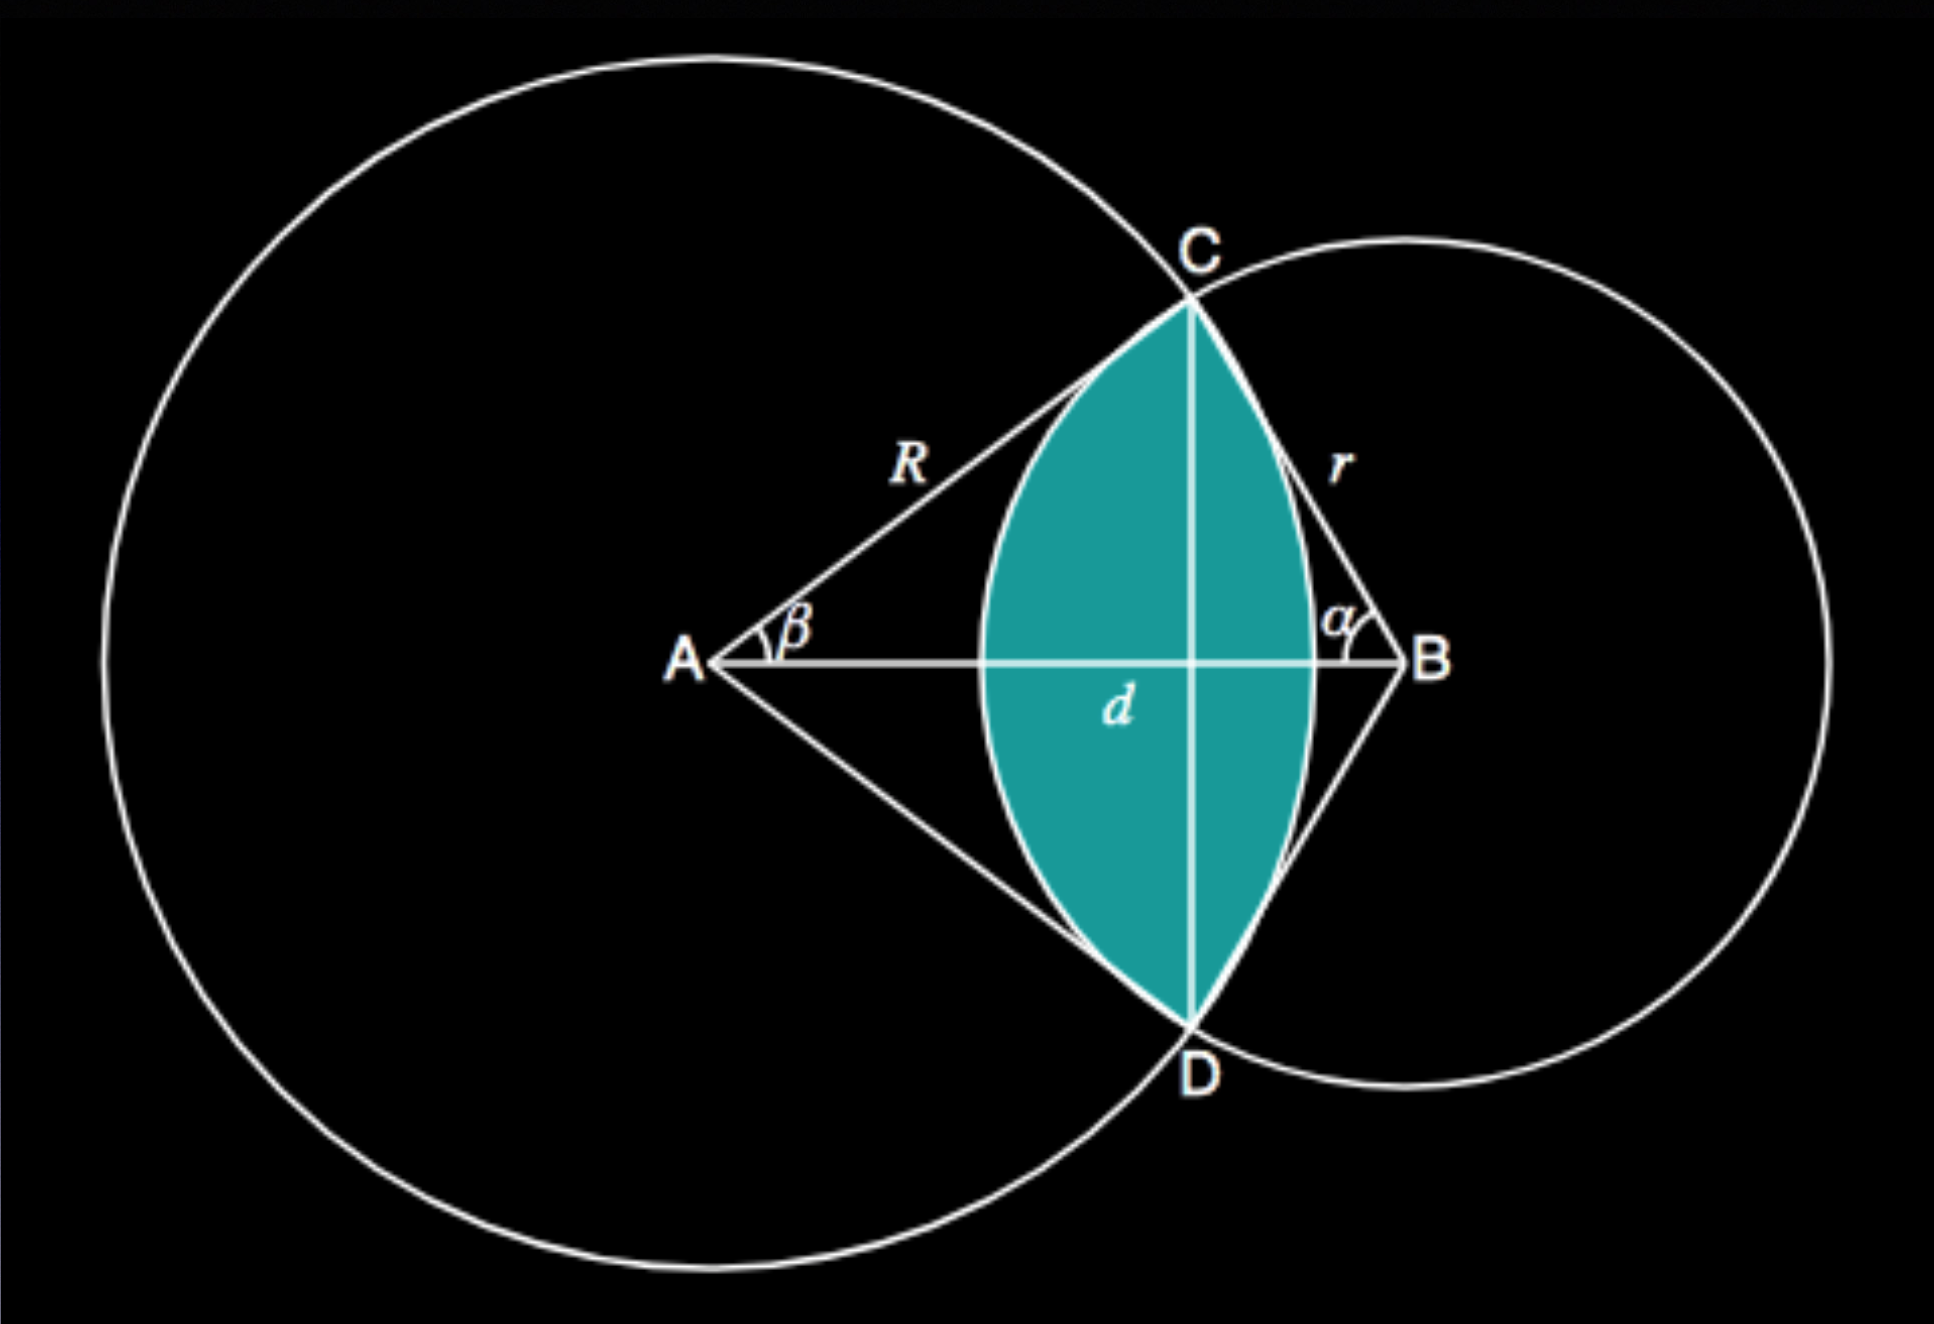

In [5]:
def eclipse_coverage(distance,R,r): #this function calculates the area covered using geometry in the picture shown below
    if(distance >= R+r):
        return 0
    if(distance <= abs(R-r)):
        return np.pi*r**2
    theta1 = np.arccos((distance**2 + r**2 - R**2)/(2 * distance * r))
    theta2 = np.arccos((distance**2 + R**2 - r**2)/(2 * distance * R))
    return ( r**2 * theta1 + R**2 * theta2 - 0.5 * (r**2 * np.sin(2*theta1) + R**2 * np.sin(2*theta2)))
Image(filename='geometry.png')

This function below sets the objects in motion around each other along your line of sight and allows the code to keep track of the objects' positions as the system evolves.

In [6]:
def positions(t,star_mass,planet_mass):
    star_position = (planet_mass/(star_mass+planet_mass))*np.cos(2*np.pi*t)
    planet_position = -(star_mass/(star_mass+planet_mass))*np.cos(2*np.pi*t)
    return star_position, planet_position

The function below is used to simulate the reflection effect from the companion object.

In [13]:
def companion_flux(t,primary_flux,companion_radius,offset):
    A = (primary_flux * ((np.pi * (companion_radius**2))/(4*np.pi)))/2  #computes amplitude as a fraction of the primary flux
    A = 0.04 #sometimes easier to define it
    return(A*np.sin(2*np.pi*t + offset) + A)

These next few functions create plots with time and flux data that you pass in and prevent you from having to copy and paste all of the tick parameters that I used.  I have a dark theme applied to my jupyter notebook, so I have all of my axes, ticks, text, and numbers set to white as well as a face color of none; if you don't use a dark themed notebook, you can just set everything marked white to black and comment out the facecolor statement to get normal plots.  I have one cell below that I copy and pasted the code to make a plot with two data sets on the same graph; it was easier to do this for the one time I plotted this than to copy and paste or type out f,ax = plt.subplots() every time I wanted to make a plot with my functions.

In [14]:
def nice_plot(t,y,c,tlab,ylab):
    f,ax = plt.subplots()

    ax.plot(t,y,color=c)

    ax.set_xlabel(tlab,color='white',fontsize=14)
    ax.set_ylabel(ylab,color='white',fontsize=14)

    plt.minorticks_on()
    plt.setp(ax.get_xticklabels(),fontsize=14)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.xaxis.set_ticks_position('both'); ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='x',which='major',direction='in',length=6); ax.tick_params(axis='y',which='major',direction='in',length=6)
    ax.tick_params(axis='x',which='minor',direction='in',length=4); ax.tick_params(axis='y',which='minor',direction='in',length=4)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['top'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(axis='x',which='both',colors='white')
    ax.tick_params(axis='y',which='both',colors='white')
    ax.set_facecolor("None")

In [15]:
def nice_scatter(t,y,c,tlab,ylab):
    f,ax = plt.subplots()

    ax.scatter(t,y,color=c)

    ax.set_xlabel(tlab,color='white',fontsize=14)
    ax.set_ylabel(ylab,color='white',fontsize=14)

    plt.minorticks_on()
    plt.setp(ax.get_xticklabels(),fontsize=14)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.xaxis.set_ticks_position('both'); ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='x',which='major',direction='in',length=6); ax.tick_params(axis='y',which='major',direction='in',length=6)
    ax.tick_params(axis='x',which='minor',direction='in',length=4); ax.tick_params(axis='y',which='minor',direction='in',length=4)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['top'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(axis='x',which='both',colors='white')
    ax.tick_params(axis='y',which='both',colors='white')
    ax.set_facecolor("None")

In [16]:
def modeling_plot(t1,y1,c1,t2,y2,c2,tlab,ylab):
    f,ax = plt.subplots()

    ax.scatter(t1,y1,color=c1)
    ax.plot(t2,y2,color=c2)

    ax.set_xlabel(tlab,color='white',fontsize=14)
    ax.set_ylabel(ylab,color='white',fontsize=14)

    plt.minorticks_on()
    plt.setp(ax.get_xticklabels(),fontsize=14)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.xaxis.set_ticks_position('both'); ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='x',which='major',direction='in',length=6); ax.tick_params(axis='y',which='major',direction='in',length=6)
    ax.tick_params(axis='x',which='minor',direction='in',length=4); ax.tick_params(axis='y',which='minor',direction='in',length=4)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['top'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(axis='x',which='both',colors='white')
    ax.tick_params(axis='y',which='both',colors='white')
    ax.set_facecolor("None")

# Parameters

Now we can get into making the light curves.  I give the star and planet and some parameters and then compute the positions.  All of the primary stars that I am concerned about studying are around a mass 0.5Msun and radius of 0.2Rsun, so I would stay below 0.7Msun and 0.4Msun for all of these.  The companion parameters depends on if you are using a planet or a lom-mass star; I would stay below about 0.2Rsun for these.

In [17]:
N = 500

t = np.linspace(0,2,N)  #phase

#if looking at the planetary model
primary = star(0.5,1.0,np.linspace(1,1,N),0)   # radius, mass, flux, position
companion = planet(0.1,0.1,0,0)    

#if looking at the HW Vir model
primary = star(.2058,0.45,np.linspace(1,1,N),0)   # r,m,f,pos
companion = star(.1739,0.12,0,0)    # radius of secondary is given in units of r1

primary.position, companion.position = positions(t,primary.mass,companion.mass) #set them in motion

companion.flux = companion_flux(t,primary.flux,companion.radius,(0.0*np.pi))

inclination_angle = 0         # inclination of system in degrees
inclination_angle = math.radians(inclination_angle) # inclination of system in radians

# Creating Some Eclipses

This code below plots the motion of the objects as I keep track of their positions.

<IPython.core.display.Javascript object>


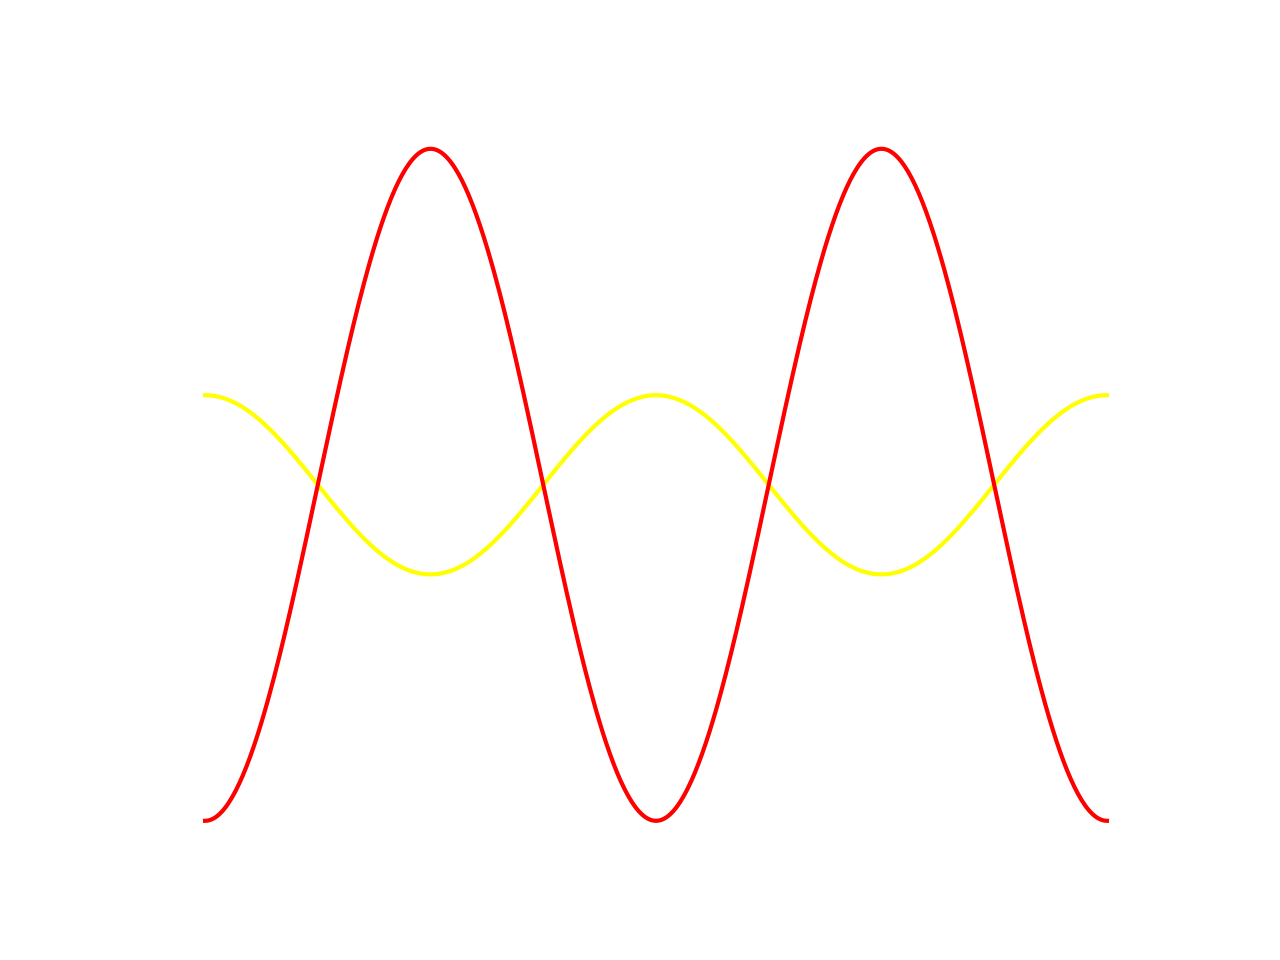

In [18]:
f,ax = plt.subplots()

ax.plot(t,primary.position,color='yellow')
ax.plot(t,companion.position,color='red')

ax.set_xlabel('Phase',color='white',fontsize=14)
ax.set_ylabel('Position',color='white',fontsize=14)

plt.minorticks_on()
plt.setp(ax.get_xticklabels(),fontsize=14)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.xaxis.set_ticks_position('both'); ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='x',which='major',direction='in',length=6); ax.tick_params(axis='y',which='major',direction='in',length=6)
ax.tick_params(axis='x',which='minor',direction='in',length=4); ax.tick_params(axis='y',which='minor',direction='in',length=4)
ax.spines['bottom'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x',which='both',colors='white')
ax.tick_params(axis='y',which='both',colors='white')
ax.set_facecolor("None")

As you can see they move with the oscillatory properties that we gave them, and you can use this position data and the radius of the stars to check when the two objects would overlap.  This is what we do below while also accounting for the inclination angle the system might be at.  These checks will help us to understand what eclipse is happening when and compute flux measurements for the system.

<IPython.core.display.Javascript object>


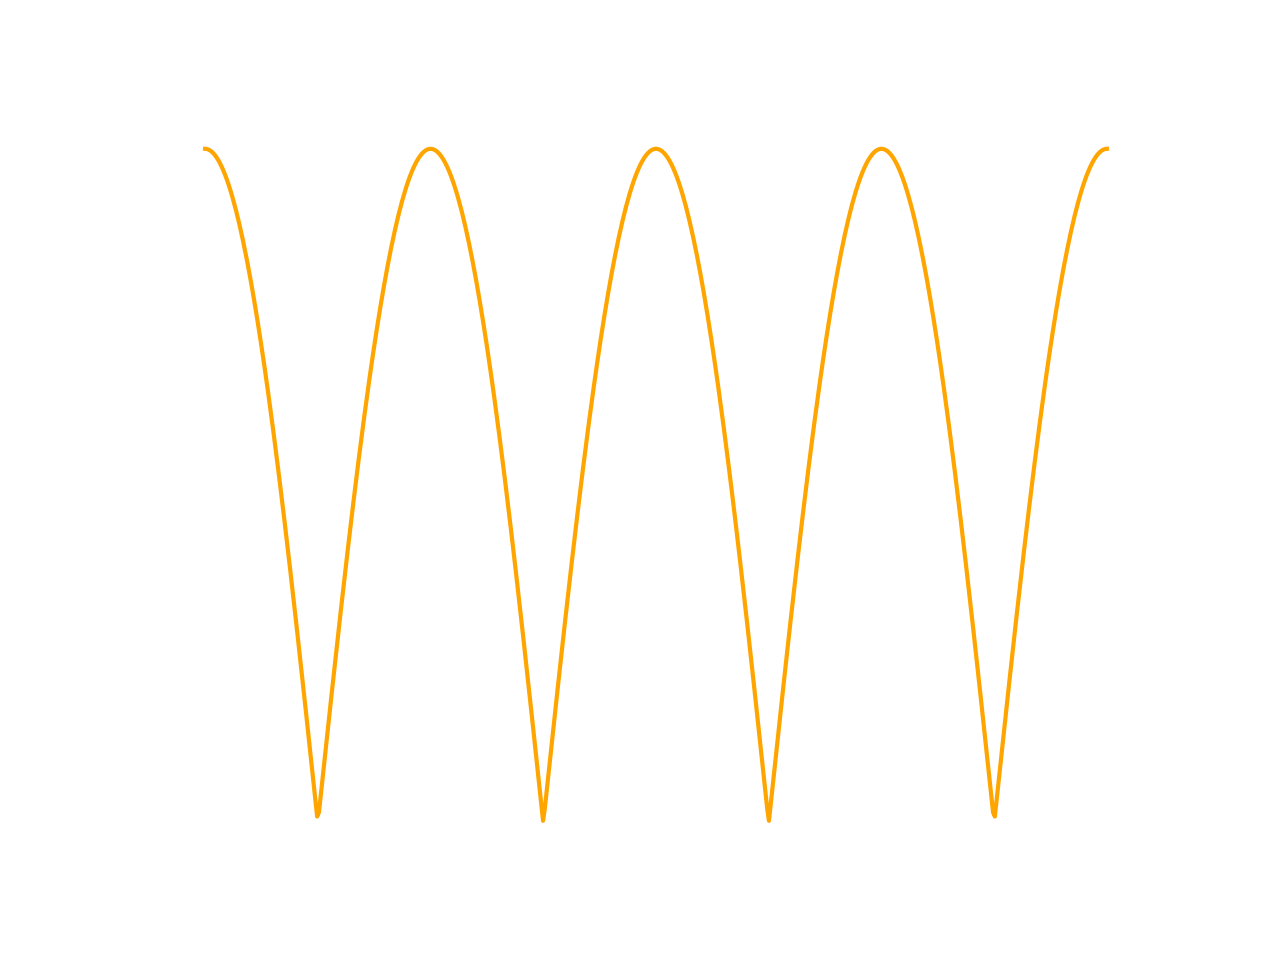

<IPython.core.display.Javascript object>


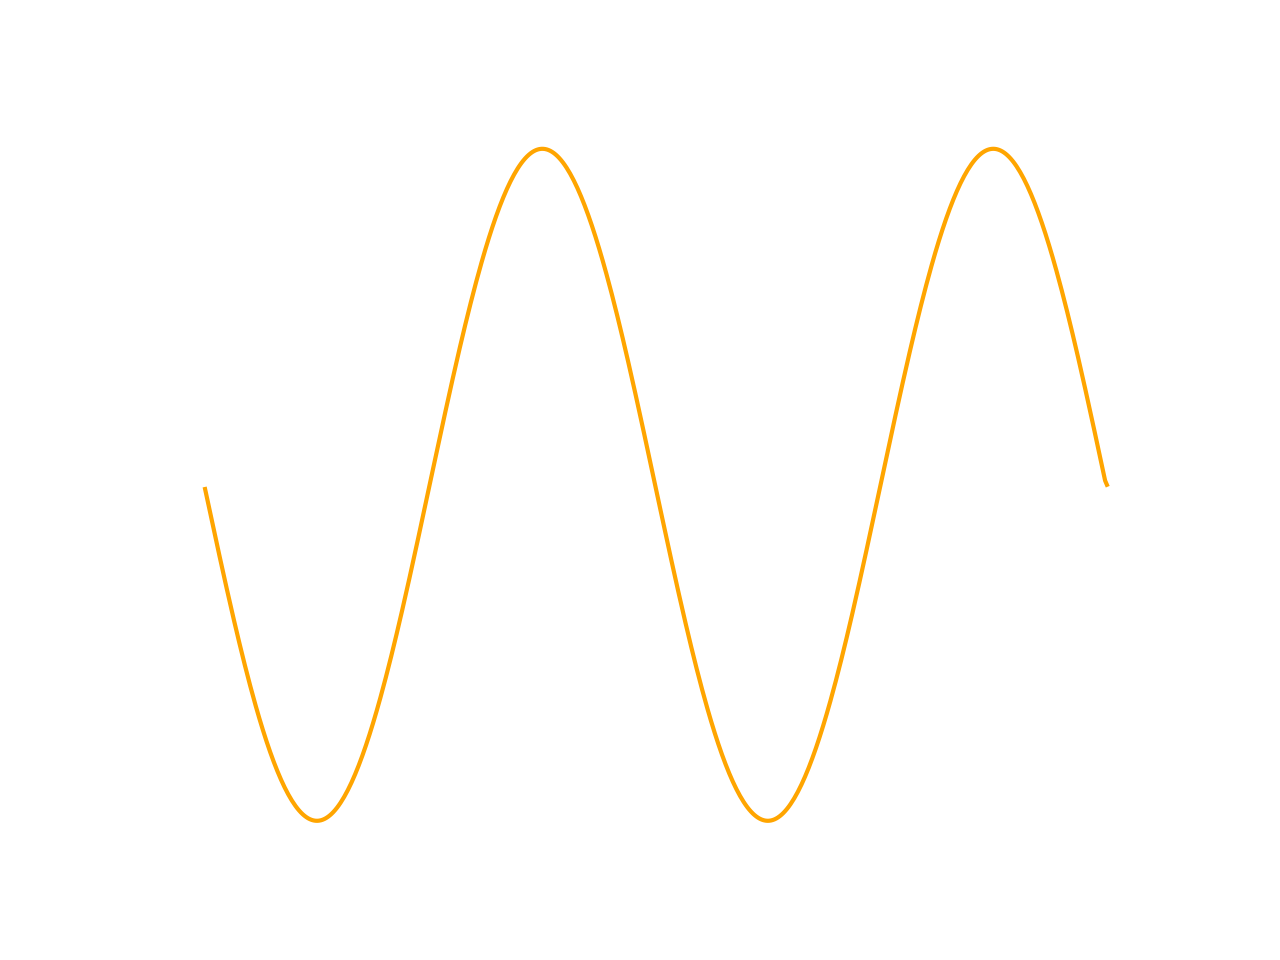

In [19]:
distance_check = []; position_check = []

orbital_separation = max(abs(primary.position)+abs(companion.position))
height = np.sin(inclination_angle)*orbital_separation

q=0
while q<len(primary.position):
    separation = abs(primary.position[q])+abs(companion.position[q])
    distance_check.append(np.sqrt(separation**2 + height**2))
    q+=1

j=1
while j<len(primary.position):
    position_check.append(primary.position[j]-primary.position[j-1])
    j+=1
    
position_check.append(0)
nice_plot(t,distance_check,'orange','Phase','Distance')
nice_plot(t,position_check,'orange','Phase','Position')

Now that we have our checks, we can compute the flux of the system and then create a light curve.  I have two sections of checks you can comment in and out.  One is for a planetary model and one is for the HW Vir model.  

In [27]:
system_flux = []

eclipse_check = False

j=0

while j<len(primary.position):
    #these checks are needed for both models
    if(position_check[j]<0):
        eclipse_check = True
    if(position_check[j]==0):
        eclipse_check = False  
    if(position_check[j]>0):
        eclipse_check = False
        
        
    #planetary model checks only
    if((distance_check[j]<(primary.radius+companion.radius))and(eclipse_check==True)): #checks if the planet blocks the star
        companion_coverage = eclipse_coverage(distance_check[j],primary.radius,companion.radius)/(np.pi*primary.radius**2)
        system_flux.append(primary.flux[j]*(1-companion_coverage))
        
    if((distance_check[j]<(primary.radius+companion.radius))and(eclipse_check==False)): #checks if the star blocks the planet
        companion_coverage = eclipse_coverage(distance_check[j],primary.radius,companion.radius)/(np.pi*primary.radius**2)
        system_flux.append(primary.flux[j])
        
    if(distance_check[j]>=(primary.radius+companion.radius)):  #no coverage at all
        system_flux.append(primary.flux[j])
        
#     #HW Vir checks only
#     if((distance_check[j]<(primary.radius+companion.radius))and(eclipse_check==True)): #checks if the planet blocks the star
#         companion_coverage = eclipse_coverage(distance_check[j],primary.radius,companion.radius)/(np.pi*primary.radius**2)
#         system_flux.append((primary.flux[j]) + (companion.flux[j] * (1-companion_coverage)))
        
#     if((distance_check[j]<(primary.radius+companion.radius))and(eclipse_check==False)): #checks if the star blocks the planet
#         companion_coverage = eclipse_coverage(distance_check[j],primary.radius,companion.radius)/(np.pi*primary.radius**2)
#         system_flux.append((primary.flux[j] * (1-companion_coverage) + (companion.flux[j])))
        
#     if(distance_check[j]>=(primary.radius+companion.radius)):  #no coverage at all
#         system_flux.append(primary.flux[j]+companion.flux[j])
        
    j+=1

<IPython.core.display.Javascript object>


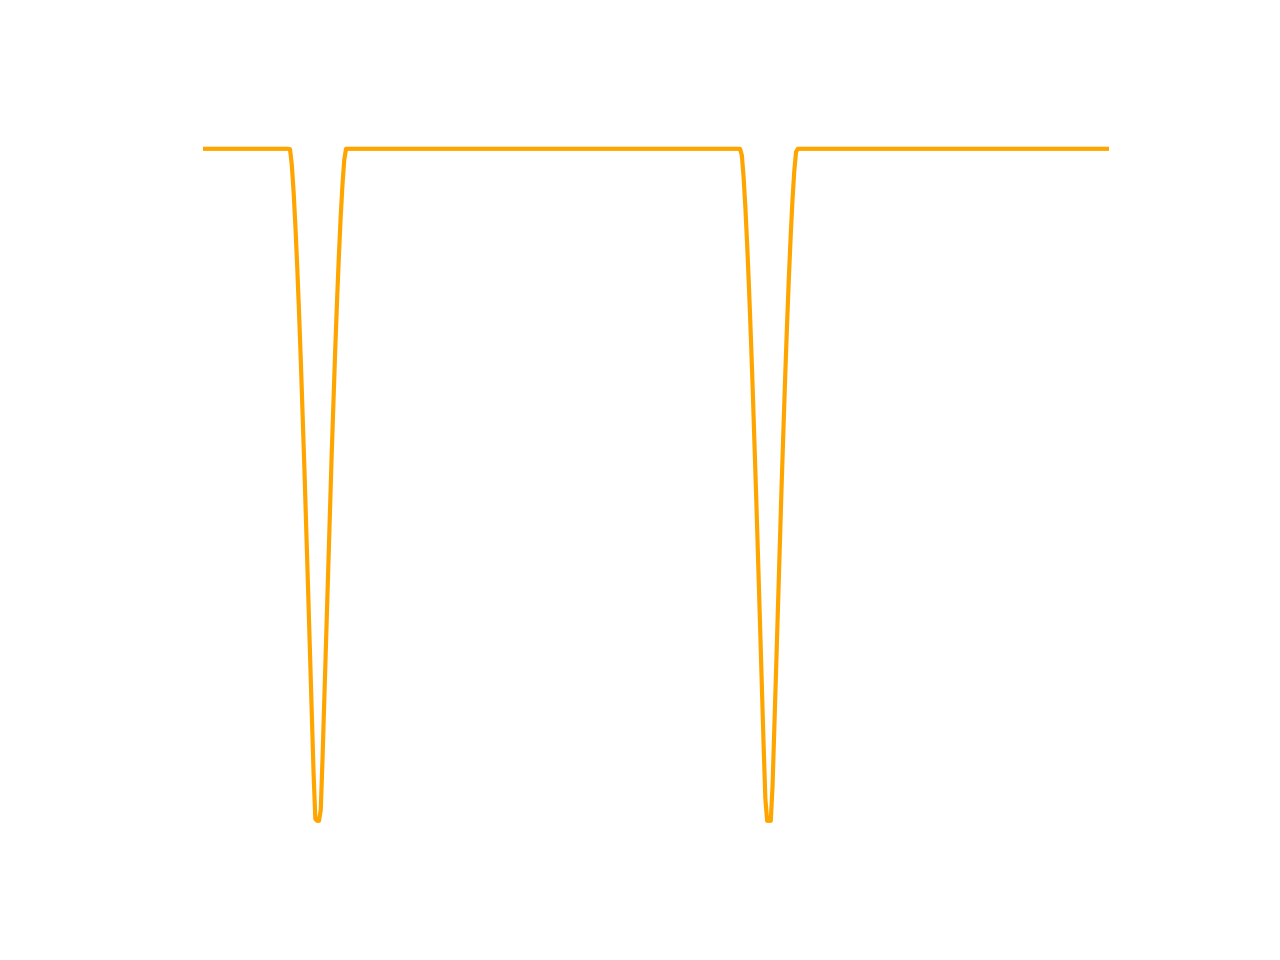

In [28]:
nice_plot(t,system_flux,'orange','Phase','Flux') #plots the flux vs time graph

As you can see, we get a nice transit from the planet with the planetary checks on!  This looks more like a model light curve, though, so my next step was to add noise to make it look more like real data.

In [29]:
noise = np.random.normal(0,0.005,N) #used for planet
noise = np.random.normal(0,0.02,N) #used for HW Vir

observed_flux = []

j=0
while j<len(system_flux):
    observed_flux.append(system_flux[j]+noise[j])
    j+=1


<IPython.core.display.Javascript object>


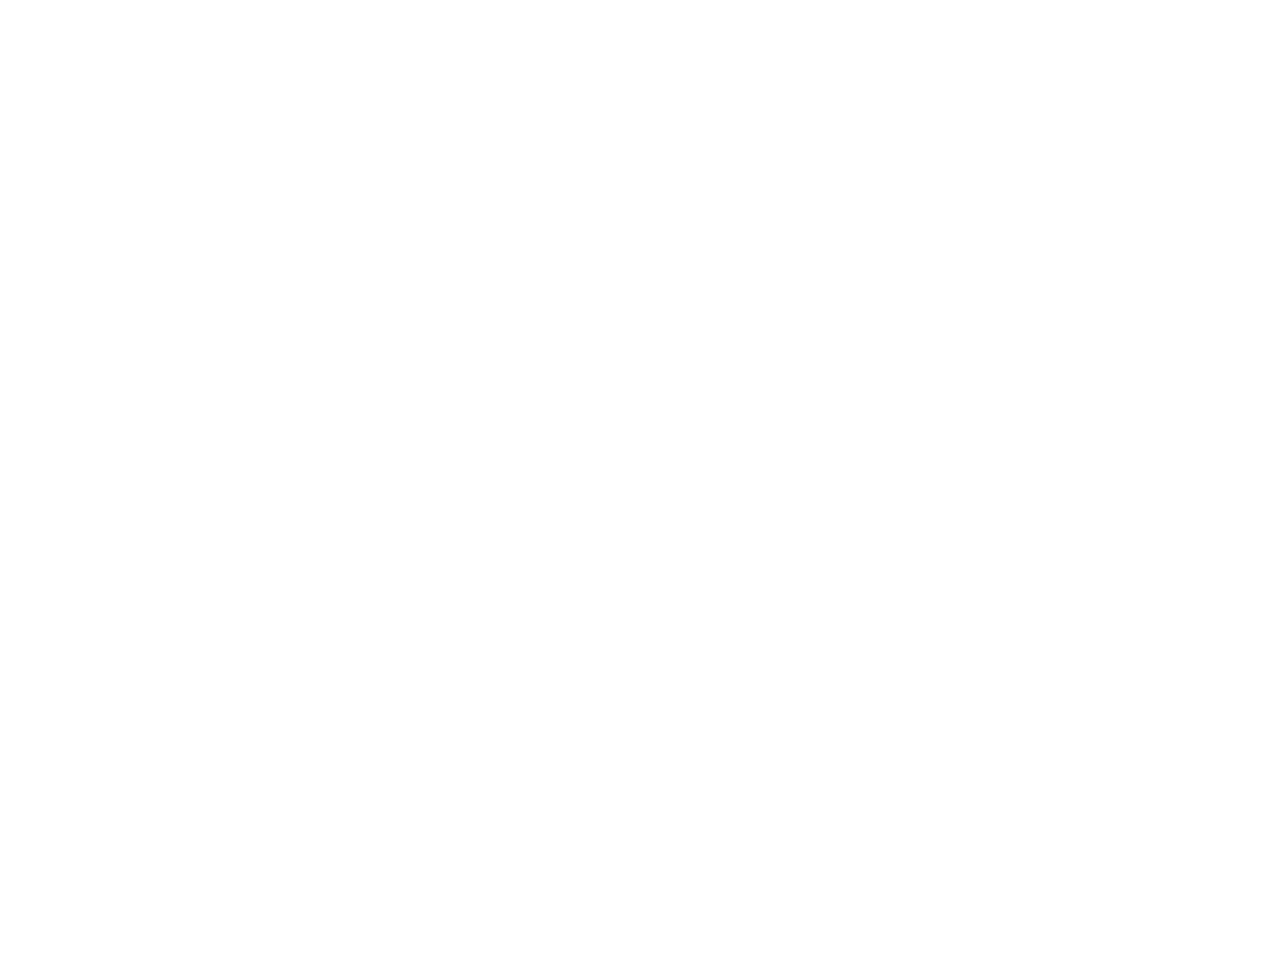

In [30]:
nice_scatter(t,observed_flux,'white','Phase','Flux')

Now we have something that looks like a real data set as well as the model that goes with it!  The two are plotted below.

<IPython.core.display.Javascript object>


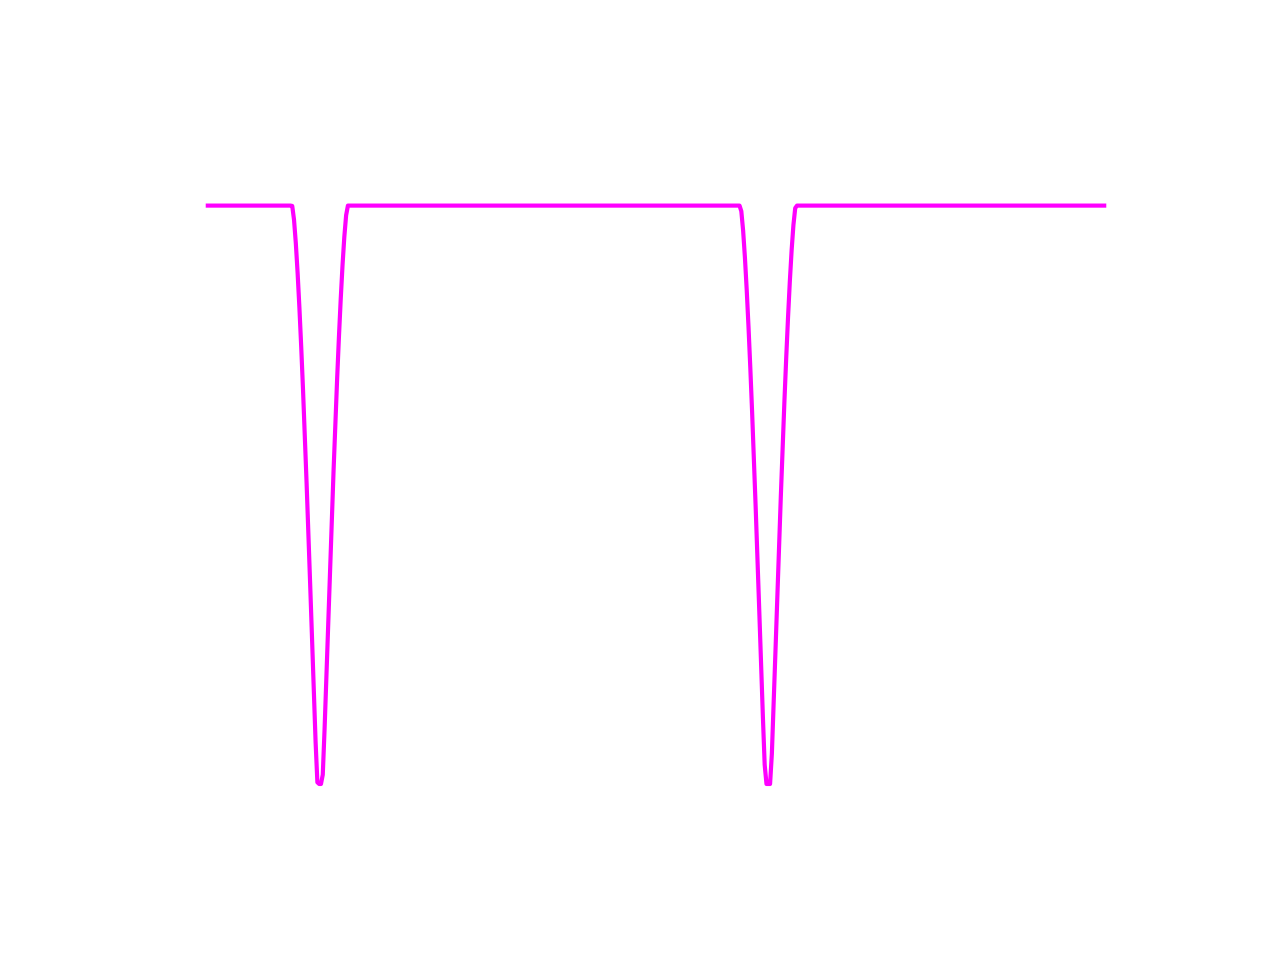

In [31]:
modeling_plot(t,observed_flux,'white',t,system_flux,'magenta','Phase','Flux')

This is very exciting that we can generate these data sets.  Also, to be able to have the model they were created from would be very helpful in understanding the nature of the system when we generate many of them and do O-C analysis.

# Summary and Going Forward

We used simple geometry to generate light curves that model astrophysical systems.  We did a few things computationally that allowed us to have both a model light curve and something that looked like real observational data.  This was an extremely exciting project to do because it can help me to further investigate things in my own research.

Going forward, I would like to be able to add in the ellipsoidal modulation to study different systems than transiting planets and HW Virs.  I also want to be able to generate large amounts of data with different parameters to be able to study and characterize types of systems -- hopefully implenting neural networks to classify the outputs.  I also want to use the HW Vir light curves to study the Romer Delay with O-C analysis.